# Data Scraping & Selenium

In [1]:
# Import Library (Scraping)

import chromedriver_binary  # Adds chromedriver binary to path
from selenium import webdriver
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np

import time
import re

from matplotlib import pyplot as plt
import seaborn as sns

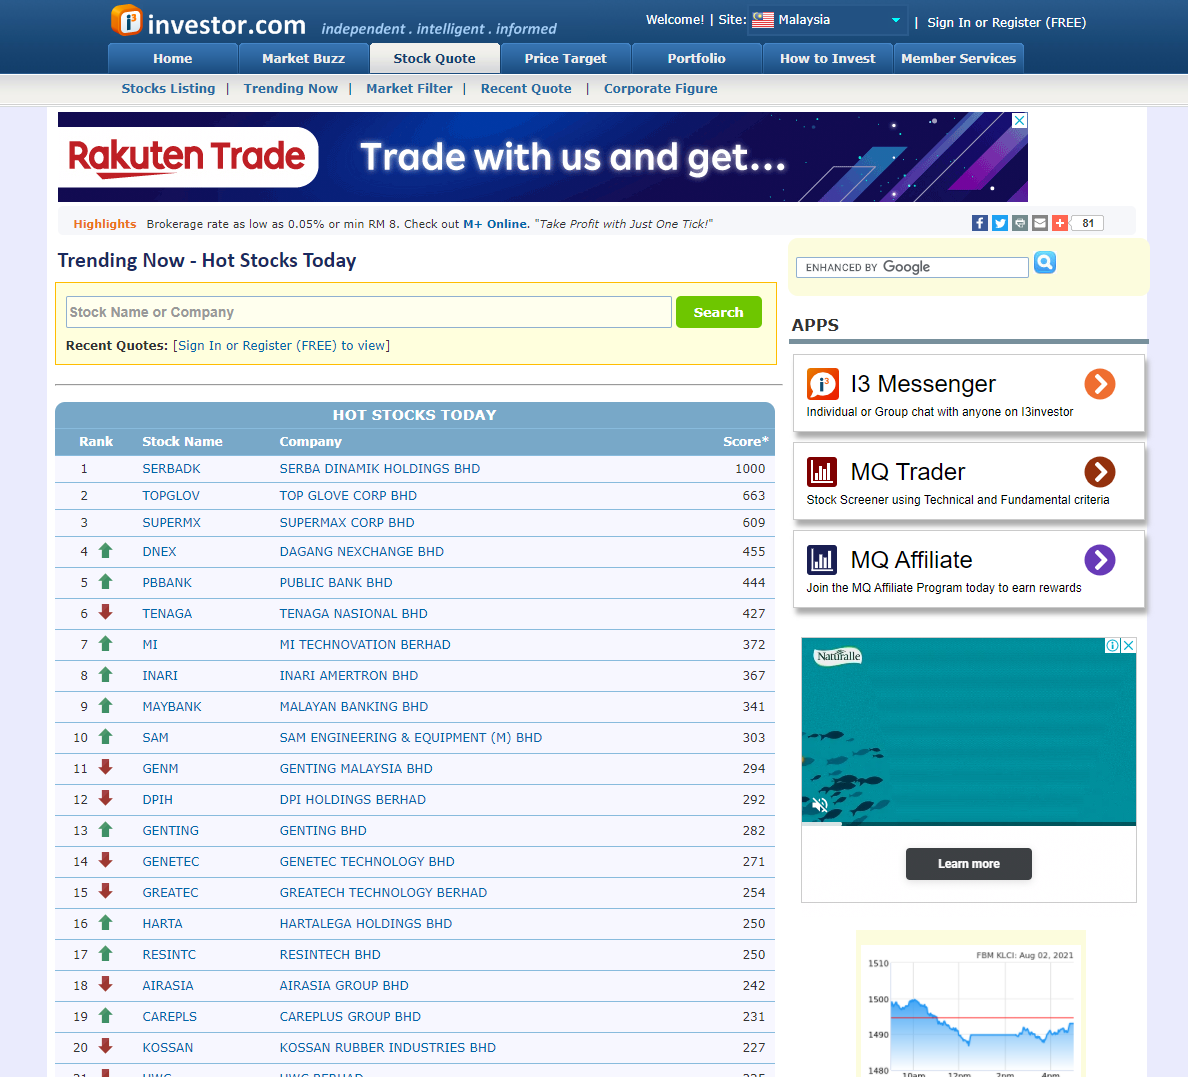

The website we trying to scrap is https://klse.i3investor.com/ or more specifically, the ***top 30 Hot Stock*** in the forums

In the front view, we observed that the webpage has their own standard and scoring, based on the criteria below

**Note 1**: Stock trends are derived from a number of activities related to the stock, each given a weightage and score. The activities contributing to stock scores include:
* Searches on a stock
* News & blog posts covering a stock
* Price target for a stock
* Announcement on a stock
* Stock entitlement (bonus, dividend, split, consolidation)

**Note 2**: The scores are normalised to have maximum score of 1000. Stock with the highest score has the most activities in the past 2 days.

Hence first we will try to scrap all the data available in this page as follows


In [2]:
# Initiate Chrome webdriver
driver = webdriver.Chrome()

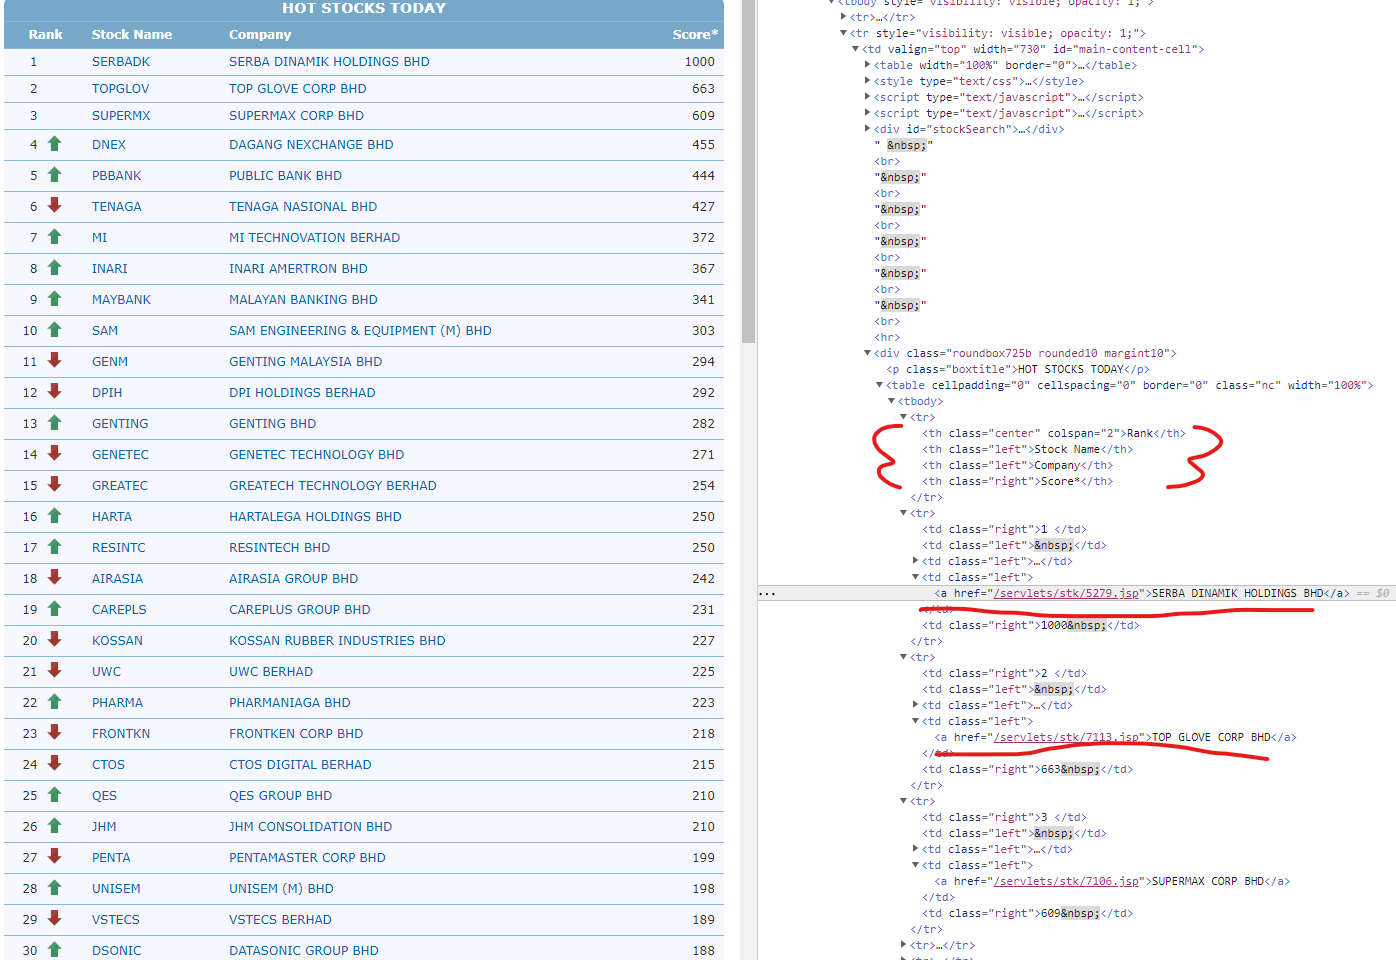

In [3]:
# define the main url and the appending trend url, 
# the main url will be use throughout the whole scraping process or accessing other link

main_url = 'https://klse.i3investor.com'
trend_url = '/jsp/quotetrend.jsp'

# Initializing local variables (list)
header = []
details = []

# Fetch webpage
driver.get(main_url+trend_url)

# load data into beautifulSoup
soup = BeautifulSoup(driver.page_source,'html.parser')

# Initializing the main data table
main = soup.find('div',attrs={'class':'roundbox725b rounded10 margint10'})

# Get Header & Data
for tr in main.find_all('tr'):
    tempdata  = []       # reset list data for each loop
    stock_url = ''       # reset url string for each loop
    
    # for each child (descendant) of 'tr'
    for rowtype in tr:
        if rowtype.name == 'th':            # if table header
            header.append(rowtype.text)     # store header
            
        elif rowtype.name == 'td':          # if table data
            tempdata.append(rowtype.text)   # store data in a temporarily list
            
            if rowtype.contents[0].name == 'a':        # if table data contains link (url)
                stock_url = rowtype.a.attrs['href']    # fetch href components
    
    if len(tempdata) > 1:                       # to exclude first row which is header
        tempdata.pop(1)                         # removing 2nd columns (green and red arrow)
        tempdata.append(stock_url)              # appending stock url for further scraping
        details.append(tempdata)                # store final data



# Convert to Dataframe and rename columns
header.append('Stock_Url')
df_hotstock = pd.DataFrame(details, columns = header)
df_hotstock.rename(columns={'Score*': 'Score',
                        'Stock Name': 'Stock_Name'}, inplace=True)

df_hotstock

,Rank,Stock_Name,Company,Score,Stock_Url
0,1,TOPGLOV,TOP GLOVE CORP BHD,1000,/servlets/stk/7113.jsp
1,2,SERBADK,SERBA DINAMIK HOLDINGS BHD,831,/servlets/stk/5279.jsp
2,3,SUPERMX,SUPERMAX CORP BHD,777,/servlets/stk/7106.jsp
3,4,DNEX,DAGANG NEXCHANGE BHD,594,/servlets/stk/4456.jsp
4,5,AIRASIA,AIRASIA GROUP BHD,412,/servlets/stk/5099.jsp
5,6,PHARMA,PHARMANIAGA BHD,393,/servlets/stk/7081.jsp
6,7,CAREPLS,CAREPLUS GROUP BHD,393,/servlets/stk/0163.jsp
7,8,GENTING,GENTING BHD,370,/servlets/stk/3182.jsp
8,9,MAYBANK,MALAYAN BANKING BHD,365,/servlets/stk/1155.jsp
9,10,PBBANK,PUBLIC BANK BHD,341,/servlets/stk/1295.jsp


In [4]:
# function to find the social forum url and return results
def get_forum_url(s_url):
    
    # Fetch stock webpage
    driver.get(s_url)
    
    # load data into beautifulSoup
    soup = BeautifulSoup(driver.page_source,'html.parser')
    
    # Find the div tag with class = 'comtbtop'
    div_comtbtop = soup.find('div',attrs={ 'class':'comtbtop'})
    
    # register forum url
    for link in div_comtbtop.find_all('a'):
        if 'href' in link.attrs:
            href = link.attrs['href']
            result = re.findall(r'^\/servlets\/forum\/[\d\w\.]+', href)
            if len(result) > 0:
                return result[0]

page illustration as follows:
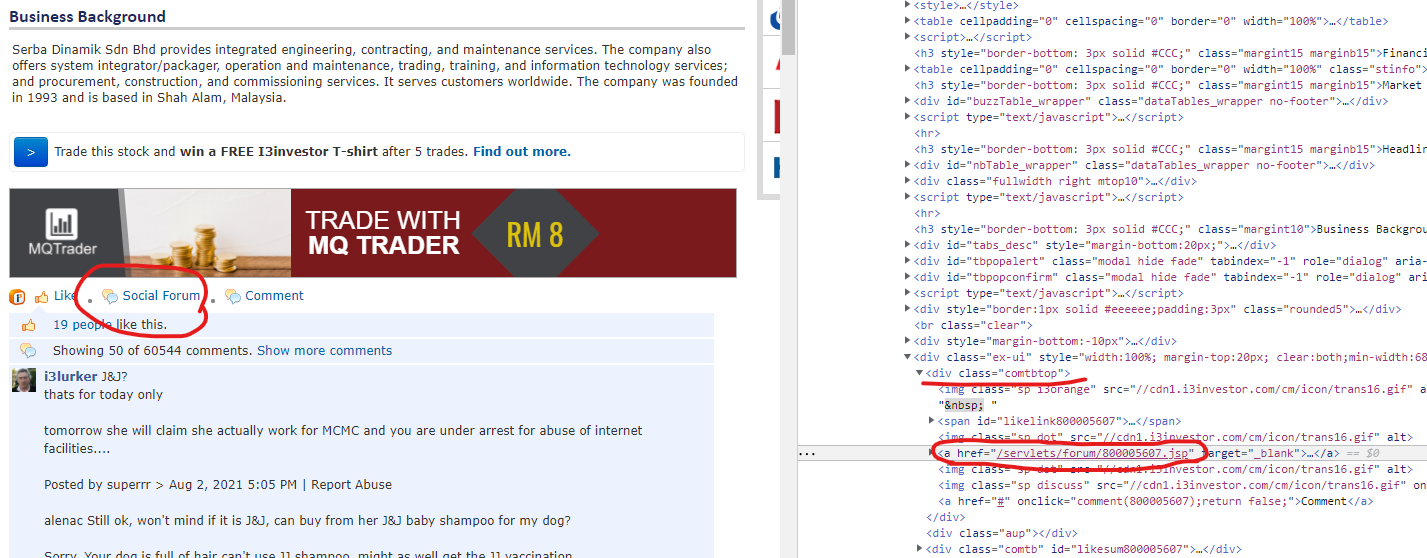

In [5]:
# Start Timer
start = time.time()

# Get forum url from stock page, using main url + stock servlet
df_hotstock['Forum_Url'] = df_hotstock['Stock_Url'].map(lambda x: get_forum_url(main_url + x))
# EG: main url = https://klse.i3investor.com, x = /servlets/stk/7113.jsp --> https://klse.i3investor.com/servlets/stk/7113.jsp

# End Timer
end = time.time()
print(end - start) # in seconds

16.70681858062744


In [6]:
# results as follows
df_hotstock

,Rank,Stock_Name,Company,Score,Stock_Url,Forum_Url
0,1,TOPGLOV,TOP GLOVE CORP BHD,1000,/servlets/stk/7113.jsp,/servlets/forum/800001345.jsp
1,2,SERBADK,SERBA DINAMIK HOLDINGS BHD,831,/servlets/stk/5279.jsp,/servlets/forum/800005607.jsp
2,3,SUPERMX,SUPERMAX CORP BHD,777,/servlets/stk/7106.jsp,/servlets/forum/800001331.jsp
3,4,DNEX,DAGANG NEXCHANGE BHD,594,/servlets/stk/4456.jsp,/servlets/forum/800000692.jsp
4,5,AIRASIA,AIRASIA GROUP BHD,412,/servlets/stk/5099.jsp,/servlets/forum/800000864.jsp
5,6,PHARMA,PHARMANIAGA BHD,393,/servlets/stk/7081.jsp,/servlets/forum/800001303.jsp
6,7,CAREPLS,CAREPLUS GROUP BHD,393,/servlets/stk/0163.jsp,/servlets/forum/800000181.jsp
7,8,GENTING,GENTING BHD,370,/servlets/stk/3182.jsp,/servlets/forum/800000520.jsp
8,9,MAYBANK,MALAYAN BANKING BHD,365,/servlets/stk/1155.jsp,/servlets/forum/800000318.jsp
9,10,PBBANK,PUBLIC BANK BHD,341,/servlets/stk/1295.jsp,/servlets/forum/800000339.jsp


In [7]:
df_hotstock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Rank        30 non-null     object
 1   Stock_Name  30 non-null     object
 2   Company     30 non-null     object
 3   Score       30 non-null     object
 4   Stock_Url   30 non-null     object
 5   Forum_Url   30 non-null     object
dtypes: object(6)
memory usage: 1.5+ KB


In [8]:
# Checkpoint 1
# Store as csv (to avoid original data lost during further data manipulation and transforming)
df_hotstock.to_csv('Data/df_hotstock.csv', index=False)

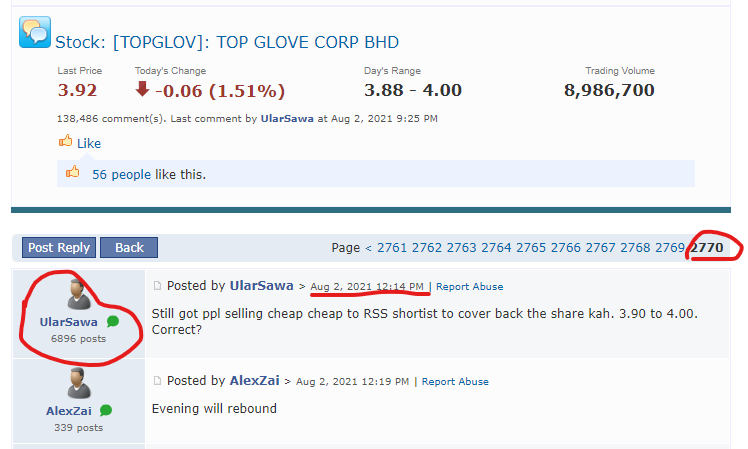

Next, after fetching the forum url, the following actions are done by looping each **30 Hot Stocks**

 1. Loading the first forums url in df_hotstock
 2. Get total page number in forums (All forums is in descending order: latest comments will be shown)
 3. Scrap the current page (Eg: Page 2770)
 4. For each comment box
     * User ID (Eg: UlarSawa )
     * Total Post Contribution (Eg: 6896 posts)
     * Posting date (Eg: Aug 2, 2021 12:14PM)
     * Comments
 5. Append stored details in global lists
 6. Accessing *Previous* Page (Eg: Page 2769)
 7. Repeat steps 4 & 5
 8. Scrap for totals of 11 pages (Approximate 500 comments for each stock)
 9. Load the next forums url in df_hotstock
 10. Repeat steps 2 to steps 9 for all 30 stocks
 
30 Stocks X 11 pages X 45 comments ~~ 15000++ Commments scraped

In [9]:
# Function to obtain final page number in each forums (Only run once per forums, 30 forums =  30 times)
def forum_load(f_url, stock_name): 
    
    # Fetch page with forum full url
    driver.get(f_url)
    
    # load data into beautifulSoup
    soup = BeautifulSoup(driver.page_source,'html.parser')
    
    for child in soup.find('table',attrs={'class':'marginb5 fpagenum'}).descendants:
        if child.name == 'b':
            final_page = int(child.text)
    
    # passing along forum url & and stock name to next functions, along with final page number
    forum_scrap(f_url, stock_name, final_page)


In [10]:
# Function to register page number, and load next (previous) page  (per forums = 30 times)
def forum_scrap(url, stock_name, final_pagination):
    
    #Register Current Page
    current_page = final_pagination
    
    # Scrap maximum of 11 pages each forum (around 500 records per stock)
    while (current_page >= 1) & (final_pagination - current_page < 11):

        # Call next function to perform scraping and passing the stock name
        data_scraping(stock_name)

        next_page = current_page-1 #descending order

        # Register new Url
        new_url = url + "?ftp=" + str(next_page)

        # Call next page
        driver.get(new_url)

        # Register new page and proceed next loop
        current_page = next_page

In [11]:
# Define a data scraping function
def data_scraping(stock):
    
    # load data into beautifulSoup
    soup = BeautifulSoup(driver.page_source,'html.parser')
    
    # Initializing the main data table
    table = soup.find('table',attrs={'id':'mainforum', 'class':'forum marginb5'})

    for tr in table.find_all('tr'):

        user = tr.find('span',attrs={'class':'comuid'})
        total = tr.find('span',attrs={'class':'postcount'})
        date = tr.find('span',attrs={'class':'comdt'})
        com = tr.find('span',attrs={'class':'autolink'})
        
        # Initialize a flag to skip list append if any 4 of the data not presents 
        skip = False
        
        # to avoid scraping ads and hit error due to dimension issue, there are some ads in the same 'tr' tag without data
        if type(user) == type(None):
            skip = True
            continue

        if type(total) == type(None):
            skip = True
            continue

        if type(date) == type(None):
            skip = True
            continue
            
        if type(com) == type(None):
            skip = True
            continue
        
        # If all data presents / to avoid scraping advertisement and messed up list indexing
        if skip == False:
            stock_name.append(stock)
            user_id.append(user.text)
            total_posts.append(total.text)
            date_timestamp.append(date.text)
            comments.append(com.text)

In [12]:
# Initiate global empty list for social forum scraping
stock_name = []
user_id = []
total_posts = []
date_timestamp = []
comments = []

# Start Timer
start = time.time()

# Scrap Social Forum, by using main url + forum servlet
df_hotstock.apply(lambda row:forum_load(main_url + row['Forum_Url'], row['Stock_Name']), axis = 1)

# End Timer
end = time.time()
print(end - start) # 380 seconds

379.8949406147003


In [15]:
print((end - start)/60) # time taken in minutes (6 minutes +)

6.331582343578338


In [13]:
# Close driver
driver.close()

In [14]:
# Creating a pandas dataframe by zipping the list and rename columns
df_social = pd.DataFrame(data = list(zip(stock_name, user_id, total_posts, date_timestamp, comments)),
                 columns=['stock_name', 'user_id', 'total_posts', 'date_timestamp', 'comments'])

df_social.tail(20)

,stock_name,user_id,total_posts,date_timestamp,comments
15575,PRLEXUS,drkewsc,8 posts,"Jun 24, 2021 1:42 PM",Haven’t experience such a big drop after BI ? ...
15576,PRLEXUS,amet2017,2799 posts,"Jun 24, 2021 2:02 PM",So many cases already after BI drop. This is b...
15577,PRLEXUS,learnbyheart,403 posts,"Jun 24, 2021 2:09 PM",agree with amet..some trader just push up the ...
15578,PRLEXUS,Edwardong53,665 posts,"Jun 24, 2021 2:42 PM",Any one knows what will be the conversion pric...
15579,PRLEXUS,nubiskubissss,24 posts,"Jun 24, 2021 3:13 PM",karatdis is back wohooo
15580,PRLEXUS,drkewsc,8 posts,"Jun 24, 2021 4:16 PM","If the management doesn’t do anything , no one..."
15581,PRLEXUS,learnbyheart,403 posts,"Jun 24, 2021 4:25 PM",you expecting them to do what? become manipula...
15582,PRLEXUS,Bgt 9963,4147 posts,"Jun 24, 2021 4:43 PM",Good luck...!
15583,PRLEXUS,karadis,202 posts,"Jun 24, 2021 6:31 PM",It seems that the invesrters on klsescreener's...
15584,PRLEXUS,xcu843,887 posts,"Jun 24, 2021 6:57 PM",Better don’t bonus issue. Stock price more wor...


In [16]:
df_social.info()
# no null objects

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15595 entries, 0 to 15594
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   stock_name      15595 non-null  object
 1   user_id         15595 non-null  object
 2   total_posts     15595 non-null  object
 3   date_timestamp  15595 non-null  object
 4   comments        15595 non-null  object
dtypes: object(5)
memory usage: 609.3+ KB


In [17]:
# Checkpoint 2
# Store as csv (to avoid original data lost during further NLP processing), 
# and time savings (direct load from csv for further processing)
df_social.to_csv('Data/df_social.csv', index=False)

# NLP & Sentimental Analysis

In [201]:
# Data Loading from checkpoint 1 & 2

# df_nlp = df_social.copy()    # read from dataframe
# df_nlp = pd.read_csv(r'C:\Users\user\Downloads\df_social.csv', delimiter=',')      # read from csv

# read from csv
df_nlp = pd.read_csv('Data/df_social.csv', delimiter=',')      
df_hotstock = pd.read_csv('Data/df_hotstock.csv', delimiter=',') 

In [202]:
df_hotstock

,Rank,Stock_Name,Company,Score,Stock_Url,Forum_Url
0,1,TOPGLOV,TOP GLOVE CORP BHD,1000,/servlets/stk/7113.jsp,/servlets/forum/800001345.jsp
1,2,SERBADK,SERBA DINAMIK HOLDINGS BHD,831,/servlets/stk/5279.jsp,/servlets/forum/800005607.jsp
2,3,SUPERMX,SUPERMAX CORP BHD,777,/servlets/stk/7106.jsp,/servlets/forum/800001331.jsp
3,4,DNEX,DAGANG NEXCHANGE BHD,594,/servlets/stk/4456.jsp,/servlets/forum/800000692.jsp
4,5,AIRASIA,AIRASIA GROUP BHD,412,/servlets/stk/5099.jsp,/servlets/forum/800000864.jsp
5,6,PHARMA,PHARMANIAGA BHD,393,/servlets/stk/7081.jsp,/servlets/forum/800001303.jsp
6,7,CAREPLS,CAREPLUS GROUP BHD,393,/servlets/stk/0163.jsp,/servlets/forum/800000181.jsp
7,8,GENTING,GENTING BHD,370,/servlets/stk/3182.jsp,/servlets/forum/800000520.jsp
8,9,MAYBANK,MALAYAN BANKING BHD,365,/servlets/stk/1155.jsp,/servlets/forum/800000318.jsp
9,10,PBBANK,PUBLIC BANK BHD,341,/servlets/stk/1295.jsp,/servlets/forum/800000339.jsp


In [203]:
# Use panda built in datetime to auto convert datetime
df_nlp['date_timestamp'] = pd.to_datetime(df_nlp['date_timestamp'])

In [204]:
df_nlp.tail(20)

,stock_name,user_id,total_posts,date_timestamp,comments
15575,PRLEXUS,drkewsc,8 posts,2021-06-24 13:42:00,Haven’t experience such a big drop after BI ? ...
15576,PRLEXUS,amet2017,2799 posts,2021-06-24 14:02:00,So many cases already after BI drop. This is b...
15577,PRLEXUS,learnbyheart,403 posts,2021-06-24 14:09:00,agree with amet..some trader just push up the ...
15578,PRLEXUS,Edwardong53,665 posts,2021-06-24 14:42:00,Any one knows what will be the conversion pric...
15579,PRLEXUS,nubiskubissss,24 posts,2021-06-24 15:13:00,karatdis is back wohooo
15580,PRLEXUS,drkewsc,8 posts,2021-06-24 16:16:00,"If the management doesn’t do anything , no one..."
15581,PRLEXUS,learnbyheart,403 posts,2021-06-24 16:25:00,you expecting them to do what? become manipula...
15582,PRLEXUS,Bgt 9963,4147 posts,2021-06-24 16:43:00,Good luck...!
15583,PRLEXUS,karadis,202 posts,2021-06-24 18:31:00,It seems that the invesrters on klsescreener's...
15584,PRLEXUS,xcu843,887 posts,2021-06-24 18:57:00,Better don’t bonus issue. Stock price more wor...


In [205]:
# removing stopwords and no informative slang from comments
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
    
def cleanData(raw_text):    

#   Remove Stopwrods
#   Custom Stopwords
#     new_words = ["missing","abstract","need","ha","soon","we","0","like","time","get","think","1","in","the","using", "show","aa","2021","year","still", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown"]
    new_words = ['lah', '2021', '2020', 'http', 'www', 'still', 'lu', 'ni', 'tak'
                 'year', '07', 'uuk', 'kluk', 'klsescreener', 'v2', 'com', 'https', 
                 'kita', 'lagi', 'hey', '06', 'sugzgodvcoa', 'also', 'rm', 'i3investor', 
                 '000', 'kikiki', 'go', 'ooi8888', '614056', 'fbclid', 'meow', 'ha' ]
    stop_words = set(stopwords.words('english'))
    stop_words = stop_words.union(set(new_words))
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    words = tokenizer.tokenize(raw_text)

    wordsFiltered=[]
    for word in words:
        if word.lower() not in stop_words:
            wordsFiltered.append(word)
    
    lem = WordNetLemmatizer()
    wordsLemmatized=[]
    #Lemmatisation
    for word in wordsFiltered:
        wordsLemmatized.append(lem.lemmatize(word))
    
#   Convert to lowercase
    str=''
    for w in wordsLemmatized:
        str = str+' '+w.lower()
    return str

In [206]:
# apply functions to across all 15000+ comments, and stored as 'cleaned_comments'
df_nlp['cleaned_comments'] = df_nlp.apply(lambda row:cleanData(row['comments']), axis = 1)
df_nlp['cleaned_comments']

# original comments are stored for sentimental analysis (to retain the sentiment and capital letter *emotions*)

0                        uk sample uk already successfully
1         delta variant become bad happen variant upgra...
2         best way let think normal flu get covid fist ...
3         typical jpm macai wearing miniskirt everyday ...
4         run mau pergi mana jalan bursa juga right cor...
                               ...                        
15590     naive child alvin1188 naive even know basic a...
15591     old news prolexus proxmask antiviral mask fir...
15592     many rubbish counter bursa negative earning c...
15593                               really rubbish counter
15594     share price bit ex bonus think 20 cent ex dro...
Name: cleaned_comments, Length: 15595, dtype: object

In [207]:
# perform sentimental analysis on each original comments
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
sentiment = df_nlp['comments'].apply(lambda x: analyzer.polarity_scores(x))

# concatenate both result under 1 new dataframe
df_nlp_vs = pd.concat([df_nlp, sentiment.apply(pd.Series)], axis=1)
df_nlp_vs

,stock_name,user_id,total_posts,date_timestamp,comments,cleaned_comments,neg,neu,pos,compound
0,TOPGLOV,JPmoreGUN,16 posts,2021-07-25 17:25:00,UK is the sample UK already successfully,uk sample uk already successfully,0.000,0.652,0.348,0.4939
1,TOPGLOV,Maridien2,607 posts,2021-07-25 17:39:00,"Delta variant also can become so bad, what hap...",delta variant become bad happen variant upgra...,0.143,0.765,0.092,-0.5706
2,TOPGLOV,UlarSawa,6659 posts,2021-07-25 17:43:00,The best way is to let those think it will be ...,best way let think normal flu get covid fist ...,0.081,0.862,0.057,0.3855
3,TOPGLOV,UlarSawa,6659 posts,2021-07-25 17:45:00,Typical JPM macai wearing miniskirt everyday a...,typical jpm macai wearing miniskirt everyday ...,0.000,0.841,0.159,0.6633
4,TOPGLOV,UlarSawa,6659 posts,2021-07-25 17:46:00,run mau pergi mana lah. still in jalan bursa j...,run mau pergi mana jalan bursa juga right cor...,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...
15590,PRLEXUS,karadis,202 posts,2021-06-25 18:10:00,"Naive child, @alvin1188 why are you so naive? ...",naive child alvin1188 naive even know basic a...,0.134,0.829,0.038,-0.8105
15591,PRLEXUS,myway,358 posts,2021-06-25 21:06:00,OLD NEWS Prolexus's ProXmask™ Antiviral Mask I...,old news prolexus proxmask antiviral mask fir...,0.000,1.000,0.000,0.0000
15592,PRLEXUS,learnbyheart,403 posts,2021-06-26 07:13:00,so many rubbish counter in bursa with negative...,many rubbish counter bursa negative earning c...,0.290,0.647,0.063,-0.9325
15593,PRLEXUS,xcu843,887 posts,2021-06-26 10:16:00,This really rubbish counter,really rubbish counter,0.000,1.000,0.000,0.0000


In [208]:
# Build a new dataframe that contains some basic analysis, average score of comments, 
# and group all 15000+ cleaned comments under 30 stocks (.tolist())

def f(x):
    d = {}
    d['total_comments']      = x['comments'].agg('count')
    d['unique_user']         = x['user_id'].agg(pd.Series.nunique)
    d['min_comments_dt']     = x['date_timestamp'].agg('min')
    d['max_comments_dt']     = x['date_timestamp'].agg('max')
    d['dt_difference']       = d['max_comments_dt'] - d['min_comments_dt']
    d['avg_negative']        = x['neg'].agg('mean')
    d['avg_neutral']         = x['neu'].agg('mean')
    d['avg_positive']        = x['pos'].agg('mean')
    d['avg_compound']        = x['compound'].agg('mean')
    d['cleaned_abstract']    = x['cleaned_comments'].tolist()  # convert to list
    
    
    return pd.Series(d, index=['total_comments', 'unique_user', 
                               'min_comments_dt', 'max_comments_dt','dt_difference',
                               'avg_negative','avg_neutral','avg_positive','avg_compound',
                               'cleaned_abstract'])

In [209]:
# group the data based on stock_name, and apply above functions, set index and sort = False
df_analysis = df_nlp_vs.groupby('stock_name', as_index=False, sort = False).apply(f)
df_analysis

,stock_name,total_comments,unique_user,min_comments_dt,max_comments_dt,dt_difference,avg_negative,avg_neutral,avg_positive,avg_compound,cleaned_abstract
0,TOPGLOV,526,96,2021-07-19 23:11:00,2021-07-25 20:38:00,5 days 21:27:00,0.068464,0.799249,0.132281,0.094314,"[ uk sample uk already successfully, delta va..."
1,SERBADK,521,92,2021-07-22 18:55:00,2021-07-25 20:20:00,3 days 01:25:00,0.087027,0.782505,0.130459,0.120703,[ good big 4 high turnover conpany every month...
2,SUPERMX,524,103,2021-07-20 14:52:00,2021-07-25 20:37:00,5 days 05:45:00,0.082769,0.801363,0.115874,0.052257,[ mean long operator release glove counter mea...
3,DNEX,510,109,2021-07-13 16:30:00,2021-07-25 20:28:00,12 days 03:58:00,0.035935,0.828071,0.135992,0.210633,"[ aug tp1 50, good morning, waiting 1 could ..."
4,AIRASIA,508,106,2021-07-13 14:51:00,2021-07-25 20:39:00,12 days 05:48:00,0.075465,0.797126,0.127398,0.095480,"[ good, tf good businessman wrong airline bus..."
5,PHARMA,513,67,2021-07-17 14:45:00,2021-07-25 20:09:00,8 days 05:24:00,0.051575,0.833912,0.114507,0.119298,[ selangor industry construction sector cv cas...
6,CAREPLS,537,130,2021-06-02 16:33:00,2021-07-25 20:07:00,53 days 03:34:00,0.051037,0.835302,0.113661,0.091896,[ pp price high price rm2 want benefit directo...
7,GENTING,538,64,2021-07-16 19:30:00,2021-07-25 20:31:00,9 days 01:01:00,0.071236,0.763413,0.165348,0.130339,[ uk 30 50k cases death 30 80 case 0 2 0 3 low...
8,MAYBANK,546,70,2021-06-21 15:09:00,2021-07-25 20:40:00,34 days 05:31:00,0.066500,0.774645,0.158841,0.213099,[ nhbeen 1 fruit dianatrader 1 fruit tolle 1 f...
9,PBBANK,513,98,2021-05-12 09:14:00,2021-07-25 17:04:00,74 days 07:50:00,0.053534,0.797251,0.149203,0.195515,[ maxsuper please give dream selling half mill...


In [210]:
# Bag of Words Implementation
from sklearn.feature_extraction.text import CountVectorizer

# Visualize top N uni-grams, bi-grams & tri-grams
def get_top_n1_words(corpus,n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words=bag_of_words.sum(axis=0)
    word_freq=[(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq=sorted(word_freq, key=lambda x:x[1],reverse=True)
    return words_freq[:n]

def get_top_n2_words(corpus,n=None):
    vec = CountVectorizer(ngram_range=(2,2),max_features=2000).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words=bag_of_words.sum(axis=0)
    word_freq=[(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq=sorted(word_freq, key=lambda x:x[1],reverse=True)
    return words_freq[:n]

def get_top_n3_words(corpus,n=None):
    vec = CountVectorizer(ngram_range=(3,3),max_features=2000).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words=bag_of_words.sum(axis=0)
    word_freq=[(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq=sorted(word_freq, key=lambda x:x[1],reverse=True)
    return words_freq[:n]

In [211]:
# obtain top Unigrams, Bigrams, Trigrams keywords for each 30 stocks
df_analysis['top_n1'] = df_analysis['cleaned_abstract'].apply(lambda x: get_top_n1_words(x, 15))
df_analysis['top_n2'] = df_analysis['cleaned_abstract'].apply(lambda x: get_top_n2_words(x, 10))
df_analysis['top_n3'] = df_analysis['cleaned_abstract'].apply(lambda x: get_top_n3_words(x,  5))

In [212]:
df_analysis

,stock_name,total_comments,unique_user,min_comments_dt,max_comments_dt,dt_difference,avg_negative,avg_neutral,avg_positive,avg_compound,cleaned_abstract,top_n1,top_n2,top_n3
0,TOPGLOV,526,96,2021-07-19 23:11:00,2021-07-25 20:38:00,5 days 21:27:00,0.068464,0.799249,0.132281,0.094314,"[ uk sample uk already successfully, delta va...","[(correct, 125), (case, 105), (covid, 104), (g...","[(delta variant, 37), (covid 19, 26), (tut tut...","[(pm report abuse, 13), (become normal flu, 9)..."
1,SERBADK,521,92,2021-07-22 18:55:00,2021-07-25 20:20:00,3 days 01:25:00,0.087027,0.782505,0.130459,0.120703,[ good big 4 high turnover conpany every month...,"[(price, 111), (pm, 107), (buy, 103), (23, 101...","[(report abuse, 61), (pm report, 52), (serba d...","[(pm report abuse, 52), (serba dinamik holding..."
2,SUPERMX,524,103,2021-07-20 14:52:00,2021-07-25 20:37:00,5 days 05:45:00,0.082769,0.801363,0.115874,0.052257,[ mean long operator release glove counter mea...,"[(glove, 132), (case, 109), (covid, 88), (delt...","[(delta variant, 43), (covid 19, 35), (next we...","[(covid 19 case, 8), (pm report abuse, 8), (ta..."
3,DNEX,510,109,2021-07-13 16:30:00,2021-07-25 20:28:00,12 days 03:58:00,0.035935,0.828071,0.135992,0.210633,"[ aug tp1 50, good morning, waiting 1 could ...","[(dnex, 140), (price, 83), (share, 67), (silte...","[(good morning, 14), (share price, 12), (next ...","[(buy sell call, 5), (foxconn bought 90, 5), (..."
4,AIRASIA,508,106,2021-07-13 14:51:00,2021-07-25 20:39:00,12 days 05:48:00,0.075465,0.797126,0.127398,0.095480,"[ good, tf good businessman wrong airline bus...","[(aa, 257), (price, 121), (year, 100), (ri, 97...","[(report abuse, 27), (aa price, 27), (rm0 75, ...","[(pm report abuse, 23), (50 coming soon, 10), ..."
5,PHARMA,513,67,2021-07-17 14:45:00,2021-07-25 20:09:00,8 days 05:24:00,0.051575,0.833912,0.114507,0.119298,[ selangor industry construction sector cv cas...,"[(sinovac, 225), (vaccine, 195), (pharma, 117)...","[(covid 19, 45), (sinovac vaccine, 28), (fake ...","[(pm report abuse, 18), (covid 19 vaccine, 13)..."
6,CAREPLS,537,130,2021-06-02 16:33:00,2021-07-25 20:07:00,53 days 03:34:00,0.051037,0.835302,0.113661,0.091896,[ pp price high price rm2 want benefit directo...,"[(glove, 97), (buy, 82), (good, 50), (red, 46)...","[(buy buy, 34), (closed red, 20), (covid 19, 1...","[(buy buy buy, 25), (hujung bulan jutawan, 8),..."
7,GENTING,538,64,2021-07-16 19:30:00,2021-07-25 20:31:00,9 days 01:01:00,0.071236,0.763413,0.165348,0.130339,[ uk 30 50k cases death 30 80 case 0 2 0 3 low...,"[(covid, 161), (genting, 128), (youtu, 117), (...","[(covid 19, 45), (top glove, 36), (report abus...","[(past 12 month, 23), (pm report abuse, 20), (..."
8,MAYBANK,546,70,2021-06-21 15:09:00,2021-07-25 20:40:00,34 days 05:31:00,0.066500,0.774645,0.158841,0.213099,[ nhbeen 1 fruit dianatrader 1 fruit tolle 1 f...,"[(price, 147), (buy, 131), (share, 110), (good...","[(good morning, 17), (long term, 12), (fund ma...","[(klse insider substantialshareholder, 8), (in..."
9,PBBANK,513,98,2021-05-12 09:14:00,2021-07-25 17:04:00,74 days 07:50:00,0.053534,0.797251,0.149203,0.195515,[ maxsuper please give dream selling half mill...,"[(pbb, 136), (bank, 112), (price, 83), (buy, 7...","[(public bank, 20), (long term, 19), (pbb shar...","[(thestar business business, 9), (business bus..."


In [213]:
# Merging all useful results (LEFT JOIN) using 'stock_name'
df_hotstock_analysis = pd.merge(left=df_hotstock, right= df_analysis , 
                          left_on ='Stock_Name', right_on = 'stock_name', how = 'left' )
df_hotstock_analysis

,Rank,Stock_Name,Company,Score,Stock_Url,Forum_Url,stock_name,total_comments,unique_user,min_comments_dt,max_comments_dt,dt_difference,avg_negative,avg_neutral,avg_positive,avg_compound,cleaned_abstract,top_n1,top_n2,top_n3
0,1,TOPGLOV,TOP GLOVE CORP BHD,1000,/servlets/stk/7113.jsp,/servlets/forum/800001345.jsp,TOPGLOV,526,96,2021-07-19 23:11:00,2021-07-25 20:38:00,5 days 21:27:00,0.068464,0.799249,0.132281,0.094314,"[ uk sample uk already successfully, delta va...","[(correct, 125), (case, 105), (covid, 104), (g...","[(delta variant, 37), (covid 19, 26), (tut tut...","[(pm report abuse, 13), (become normal flu, 9)..."
1,2,SERBADK,SERBA DINAMIK HOLDINGS BHD,831,/servlets/stk/5279.jsp,/servlets/forum/800005607.jsp,SERBADK,521,92,2021-07-22 18:55:00,2021-07-25 20:20:00,3 days 01:25:00,0.087027,0.782505,0.130459,0.120703,[ good big 4 high turnover conpany every month...,"[(price, 111), (pm, 107), (buy, 103), (23, 101...","[(report abuse, 61), (pm report, 52), (serba d...","[(pm report abuse, 52), (serba dinamik holding..."
2,3,SUPERMX,SUPERMAX CORP BHD,777,/servlets/stk/7106.jsp,/servlets/forum/800001331.jsp,SUPERMX,524,103,2021-07-20 14:52:00,2021-07-25 20:37:00,5 days 05:45:00,0.082769,0.801363,0.115874,0.052257,[ mean long operator release glove counter mea...,"[(glove, 132), (case, 109), (covid, 88), (delt...","[(delta variant, 43), (covid 19, 35), (next we...","[(covid 19 case, 8), (pm report abuse, 8), (ta..."
3,4,DNEX,DAGANG NEXCHANGE BHD,594,/servlets/stk/4456.jsp,/servlets/forum/800000692.jsp,DNEX,510,109,2021-07-13 16:30:00,2021-07-25 20:28:00,12 days 03:58:00,0.035935,0.828071,0.135992,0.210633,"[ aug tp1 50, good morning, waiting 1 could ...","[(dnex, 140), (price, 83), (share, 67), (silte...","[(good morning, 14), (share price, 12), (next ...","[(buy sell call, 5), (foxconn bought 90, 5), (..."
4,5,AIRASIA,AIRASIA GROUP BHD,412,/servlets/stk/5099.jsp,/servlets/forum/800000864.jsp,AIRASIA,508,106,2021-07-13 14:51:00,2021-07-25 20:39:00,12 days 05:48:00,0.075465,0.797126,0.127398,0.095480,"[ good, tf good businessman wrong airline bus...","[(aa, 257), (price, 121), (year, 100), (ri, 97...","[(report abuse, 27), (aa price, 27), (rm0 75, ...","[(pm report abuse, 23), (50 coming soon, 10), ..."
5,6,PHARMA,PHARMANIAGA BHD,393,/servlets/stk/7081.jsp,/servlets/forum/800001303.jsp,PHARMA,513,67,2021-07-17 14:45:00,2021-07-25 20:09:00,8 days 05:24:00,0.051575,0.833912,0.114507,0.119298,[ selangor industry construction sector cv cas...,"[(sinovac, 225), (vaccine, 195), (pharma, 117)...","[(covid 19, 45), (sinovac vaccine, 28), (fake ...","[(pm report abuse, 18), (covid 19 vaccine, 13)..."
6,7,CAREPLS,CAREPLUS GROUP BHD,393,/servlets/stk/0163.jsp,/servlets/forum/800000181.jsp,CAREPLS,537,130,2021-06-02 16:33:00,2021-07-25 20:07:00,53 days 03:34:00,0.051037,0.835302,0.113661,0.091896,[ pp price high price rm2 want benefit directo...,"[(glove, 97), (buy, 82), (good, 50), (red, 46)...","[(buy buy, 34), (closed red, 20), (covid 19, 1...","[(buy buy buy, 25), (hujung bulan jutawan, 8),..."
7,8,GENTING,GENTING BHD,370,/servlets/stk/3182.jsp,/servlets/forum/800000520.jsp,GENTING,538,64,2021-07-16 19:30:00,2021-07-25 20:31:00,9 days 01:01:00,0.071236,0.763413,0.165348,0.130339,[ uk 30 50k cases death 30 80 case 0 2 0 3 low...,"[(covid, 161), (genting, 128), (youtu, 117), (...","[(covid 19, 45), (top glove, 36), (report abus...","[(past 12 month, 23), (pm report abuse, 20), (..."
8,9,MAYBANK,MALAYAN BANKING BHD,365,/servlets/stk/1155.jsp,/servlets/forum/800000318.jsp,MAYBANK,546,70,2021-06-21 15:09:00,2021-07-25 20:40:00,34 days 05:31:00,0.066500,0.774645,0.158841,0.213099,[ nhbeen 1 fruit dianatrader 1 fruit tolle 1 f...,"[(price, 147), (buy, 131), (share, 110), (good...","[(good morning, 17), (long term, 12), (fund ma...","[(klse insider substantialshareholder, 8), (in..."
9,10,PBBANK,PUBLIC BANK BHD,341,/servlets/stk/1295.jsp,/servlets/forum/800000339.jsp,PBBANK,513,98,2021-05-12 09:14:00,2021-07-25 17:04:00,74 days 07:50:00,0.053534,

In [214]:
df_hotstock_analysis.columns

Index(['Rank', 'Stock_Name', 'Company', 'Score', 'Stock_Url', 'Forum_Url',
       'stock_name', 'total_comments', 'unique_user', 'min_comments_dt',
       'max_comments_dt', 'dt_difference', 'avg_negative', 'avg_neutral',
       'avg_positive', 'avg_compound', 'cleaned_abstract', 'top_n1', 'top_n2',
       'top_n3'],
      dtype='object')

In [215]:
# re-ordering columns
df_hotstock_analysis = df_hotstock_analysis[['Rank', 'Stock_Name', 'Company', 'Score', 'total_comments', 'unique_user', 
                      'min_comments_dt', 'max_comments_dt', 'dt_difference', 
                      'avg_negative', 'avg_neutral', 'avg_positive', 'avg_compound', 
                      'top_n1', 'top_n2', 'top_n3']]
df_hotstock_analysis

,Rank,Stock_Name,Company,Score,total_comments,unique_user,min_comments_dt,max_comments_dt,dt_difference,avg_negative,avg_neutral,avg_positive,avg_compound,top_n1,top_n2,top_n3
0,1,TOPGLOV,TOP GLOVE CORP BHD,1000,526,96,2021-07-19 23:11:00,2021-07-25 20:38:00,5 days 21:27:00,0.068464,0.799249,0.132281,0.094314,"[(correct, 125), (case, 105), (covid, 104), (g...","[(delta variant, 37), (covid 19, 26), (tut tut...","[(pm report abuse, 13), (become normal flu, 9)..."
1,2,SERBADK,SERBA DINAMIK HOLDINGS BHD,831,521,92,2021-07-22 18:55:00,2021-07-25 20:20:00,3 days 01:25:00,0.087027,0.782505,0.130459,0.120703,"[(price, 111), (pm, 107), (buy, 103), (23, 101...","[(report abuse, 61), (pm report, 52), (serba d...","[(pm report abuse, 52), (serba dinamik holding..."
2,3,SUPERMX,SUPERMAX CORP BHD,777,524,103,2021-07-20 14:52:00,2021-07-25 20:37:00,5 days 05:45:00,0.082769,0.801363,0.115874,0.052257,"[(glove, 132), (case, 109), (covid, 88), (delt...","[(delta variant, 43), (covid 19, 35), (next we...","[(covid 19 case, 8), (pm report abuse, 8), (ta..."
3,4,DNEX,DAGANG NEXCHANGE BHD,594,510,109,2021-07-13 16:30:00,2021-07-25 20:28:00,12 days 03:58:00,0.035935,0.828071,0.135992,0.210633,"[(dnex, 140), (price, 83), (share, 67), (silte...","[(good morning, 14), (share price, 12), (next ...","[(buy sell call, 5), (foxconn bought 90, 5), (..."
4,5,AIRASIA,AIRASIA GROUP BHD,412,508,106,2021-07-13 14:51:00,2021-07-25 20:39:00,12 days 05:48:00,0.075465,0.797126,0.127398,0.095480,"[(aa, 257), (price, 121), (year, 100), (ri, 97...","[(report abuse, 27), (aa price, 27), (rm0 75, ...","[(pm report abuse, 23), (50 coming soon, 10), ..."
5,6,PHARMA,PHARMANIAGA BHD,393,513,67,2021-07-17 14:45:00,2021-07-25 20:09:00,8 days 05:24:00,0.051575,0.833912,0.114507,0.119298,"[(sinovac, 225), (vaccine, 195), (pharma, 117)...","[(covid 19, 45), (sinovac vaccine, 28), (fake ...","[(pm report abuse, 18), (covid 19 vaccine, 13)..."
6,7,CAREPLS,CAREPLUS GROUP BHD,393,537,130,2021-06-02 16:33:00,2021-07-25 20:07:00,53 days 03:34:00,0.051037,0.835302,0.113661,0.091896,"[(glove, 97), (buy, 82), (good, 50), (red, 46)...","[(buy buy, 34), (closed red, 20), (covid 19, 1...","[(buy buy buy, 25), (hujung bulan jutawan, 8),..."
7,8,GENTING,GENTING BHD,370,538,64,2021-07-16 19:30:00,2021-07-25 20:31:00,9 days 01:01:00,0.071236,0.763413,0.165348,0.130339,"[(covid, 161), (genting, 128), (youtu, 117), (...","[(covid 19, 45), (top glove, 36), (report abus...","[(past 12 month, 23), (pm report abuse, 20), (..."
8,9,MAYBANK,MALAYAN BANKING BHD,365,546,70,2021-06-21 15:09:00,2021-07-25 20:40:00,34 days 05:31:00,0.066500,0.774645,0.158841,0.213099,"[(price, 147), (buy, 131), (share, 110), (good...","[(good morning, 17), (long term, 12), (fund ma...","[(klse insider substantialshareholder, 8), (in..."
9,10,PBBANK,PUBLIC BANK BHD,341,513,98,2021-05-12 09:14:00,2021-07-25 17:04:00,74 days 07:50:00,0.053534,0.797251,0.149203,0.195515,"[(pbb, 136), (bank, 112), (price, 83), (buy, 7...","[(public bank, 20), (long term, 19), (pbb shar...","[(thestar business business, 9), (business bus..."


In [216]:
# Final Checkpoint & Data Storing as pickle (to avoid list of tuple treated as string), and for further django processing
df_hotstock_analysis.to_pickle("Data/df_hotstock_analysis.pkl")

In [2]:
# Data reload (testing data retentions)
df_hotstock_analysis = pd.read_pickle("Data/df_hotstock_analysis.pkl")

In [3]:
df_hotstock_analysis.info()
# object are stored and loaded in correct (intended) Dtype

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   Rank             30 non-null     int64          
 1   Stock_Name       30 non-null     object         
 2   Company          30 non-null     object         
 3   Score            30 non-null     object         
 4   total_comments   30 non-null     int64          
 5   unique_user      30 non-null     int64          
 6   min_comments_dt  30 non-null     datetime64[ns] 
 7   max_comments_dt  30 non-null     datetime64[ns] 
 8   dt_difference    30 non-null     timedelta64[ns]
 9   avg_negative     30 non-null     float64        
 10  avg_neutral      30 non-null     float64        
 11  avg_positive     30 non-null     float64        
 12  avg_compound     30 non-null     float64        
 13  top_n1           30 non-null     object         
 14  top_n2           30 non-null

In [4]:
df_hotstock_analysis

,Rank,Stock_Name,Company,Score,total_comments,unique_user,min_comments_dt,max_comments_dt,dt_difference,avg_negative,avg_neutral,avg_positive,avg_compound,top_n1,top_n2,top_n3
0,1,TOPGLOV,TOP GLOVE CORP BHD,1000,526,96,2021-07-19 23:11:00,2021-07-25 20:38:00,5 days 21:27:00,0.068464,0.799249,0.132281,0.094314,"[(correct, 125), (case, 105), (covid, 104), (g...","[(delta variant, 37), (covid 19, 26), (tut tut...","[(pm report abuse, 13), (become normal flu, 9)..."
1,2,SERBADK,SERBA DINAMIK HOLDINGS BHD,831,521,92,2021-07-22 18:55:00,2021-07-25 20:20:00,3 days 01:25:00,0.087027,0.782505,0.130459,0.120703,"[(price, 111), (pm, 107), (buy, 103), (23, 101...","[(report abuse, 61), (pm report, 52), (serba d...","[(pm report abuse, 52), (serba dinamik holding..."
2,3,SUPERMX,SUPERMAX CORP BHD,777,524,103,2021-07-20 14:52:00,2021-07-25 20:37:00,5 days 05:45:00,0.082769,0.801363,0.115874,0.052257,"[(glove, 132), (case, 109), (covid, 88), (delt...","[(delta variant, 43), (covid 19, 35), (next we...","[(covid 19 case, 8), (pm report abuse, 8), (ta..."
3,4,DNEX,DAGANG NEXCHANGE BHD,594,510,109,2021-07-13 16:30:00,2021-07-25 20:28:00,12 days 03:58:00,0.035935,0.828071,0.135992,0.210633,"[(dnex, 140), (price, 83), (share, 67), (silte...","[(good morning, 14), (share price, 12), (next ...","[(buy sell call, 5), (foxconn bought 90, 5), (..."
4,5,AIRASIA,AIRASIA GROUP BHD,412,508,106,2021-07-13 14:51:00,2021-07-25 20:39:00,12 days 05:48:00,0.075465,0.797126,0.127398,0.095480,"[(aa, 257), (price, 121), (year, 100), (ri, 97...","[(report abuse, 27), (aa price, 27), (rm0 75, ...","[(pm report abuse, 23), (50 coming soon, 10), ..."
5,6,PHARMA,PHARMANIAGA BHD,393,513,67,2021-07-17 14:45:00,2021-07-25 20:09:00,8 days 05:24:00,0.051575,0.833912,0.114507,0.119298,"[(sinovac, 225), (vaccine, 195), (pharma, 117)...","[(covid 19, 45), (sinovac vaccine, 28), (fake ...","[(pm report abuse, 18), (covid 19 vaccine, 13)..."
6,7,CAREPLS,CAREPLUS GROUP BHD,393,537,130,2021-06-02 16:33:00,2021-07-25 20:07:00,53 days 03:34:00,0.051037,0.835302,0.113661,0.091896,"[(glove, 97), (buy, 82), (good, 50), (red, 46)...","[(buy buy, 34), (closed red, 20), (covid 19, 1...","[(buy buy buy, 25), (hujung bulan jutawan, 8),..."
7,8,GENTING,GENTING BHD,370,538,64,2021-07-16 19:30:00,2021-07-25 20:31:00,9 days 01:01:00,0.071236,0.763413,0.165348,0.130339,"[(covid, 161), (genting, 128), (youtu, 117), (...","[(covid 19, 45), (top glove, 36), (report abus...","[(past 12 month, 23), (pm report abuse, 20), (..."
8,9,MAYBANK,MALAYAN BANKING BHD,365,546,70,2021-06-21 15:09:00,2021-07-25 20:40:00,34 days 05:31:00,0.066500,0.774645,0.158841,0.213099,"[(price, 147), (buy, 131), (share, 110), (good...","[(good morning, 17), (long term, 12), (fund ma...","[(klse insider substantialshareholder, 8), (in..."
9,10,PBBANK,PUBLIC BANK BHD,341,513,98,2021-05-12 09:14:00,2021-07-25 17:04:00,74 days 07:50:00,0.053534,0.797251,0.149203,0.195515,"[(pbb, 136), (bank, 112), (price, 83), (buy, 7...","[(public bank, 20), (long term, 19), (pbb shar...","[(thestar business business, 9), (business bus..."


In [220]:
# Sort by average compounding score (Top sentimental score to lowest)
df_hotstock_analysis[['Stock_Name', 'avg_compound', 
                      'top_n1', 'top_n2', 'top_n3']].sort_values(by="avg_compound", 
                                                                 ascending = False)

,Stock_Name,avg_compound,top_n1,top_n2,top_n3
20,KGB,0.343589,"[(price, 184), (warrant, 178), (kgb, 107), (sh...","[(mother share, 43), (ex date, 42), (free warr...","[(warrant ex date, 16), (bursamalaysia market_..."
11,TENAGA,0.213312,"[(price, 119), (tenaga, 109), (buy, 81), (tnb,...","[(blue chip, 15), (good morning, 12), (next we...","[(year take dividend, 4), (tenaga nasional bhd..."
8,MAYBANK,0.213099,"[(price, 147), (buy, 131), (share, 110), (good...","[(good morning, 17), (long term, 12), (fund ma...","[(klse insider substantialshareholder, 8), (in..."
3,DNEX,0.210633,"[(dnex, 140), (price, 83), (share, 67), (silte...","[(good morning, 14), (share price, 12), (next ...","[(buy sell call, 5), (foxconn bought 90, 5), (..."
17,COMFORT,0.209453,"[(price, 120), (share, 114), (warrant, 111), (...","[(mother share, 72), (share price, 16), (rm2 3...","[(buy mother share, 11), (mother share price, ..."
10,VSTECS,0.203895,"[(good, 72), (vstecs, 68), (buy, 50), (price, ...","[(per cent, 16), (share price, 15), (bonus iss...","[(ikan bilis sell, 3), (thestar news nation, 3..."
9,PBBANK,0.195515,"[(pbb, 136), (bank, 112), (price, 83), (buy, 7...","[(public bank, 20), (long term, 19), (pbb shar...","[(thestar business business, 9), (business bus..."
23,SCOPE,0.191038,"[(scope, 117), (price, 72), (share, 69), (buy,...","[(right issue, 20), (ex date, 12), (share pric...","[(200 sq ft, 5), (right issue share, 3), (pm r..."
24,MYEG,0.190052,"[(myeg, 207), (vaccine, 105), (bonus, 70), (co...","[(bonus issue, 52), (covid 19, 48), (bp health...","[(covid 19 vaccine, 15), (mahb bp healthcare, ..."
18,QES,0.183904,"[(qes, 105), (buy, 69), (good, 55), (see, 48),...","[(long term, 22), (applied engineering, 14), (...","[(mid long term, 6), (buy dun ask, 4), (72 end..."


In [5]:
# Barplot function of most freq words (for further used in django)
def plot_top_n_words(top_words):
    top_df= pd.DataFrame(top_words)
    top_df.columns=["Word","Freq"]

    sns.set(rc={'figure.figsize':(13,8)})
    g = sns.barplot(x="Word",y="Freq", data=top_df)
    g.set_xticklabels(g.get_xticklabels(),rotation=30)

In [28]:
stock_mask = df_hotstock_analysis['Stock_Name'] == 'AIRASIA'

In [9]:
topn= df_hotstock_analysis[stock_mask]['top_n2'].values[0]
topn

[('mother share', 43),
 ('ex date', 42),
 ('free warrant', 36),
 ('bonus issue', 31),
 ('exercise price', 26),
 ('share price', 24),
 ('target price', 21),
 ('long term', 19),
 ('warrant ex', 19),
 ('industrial gas', 17)]

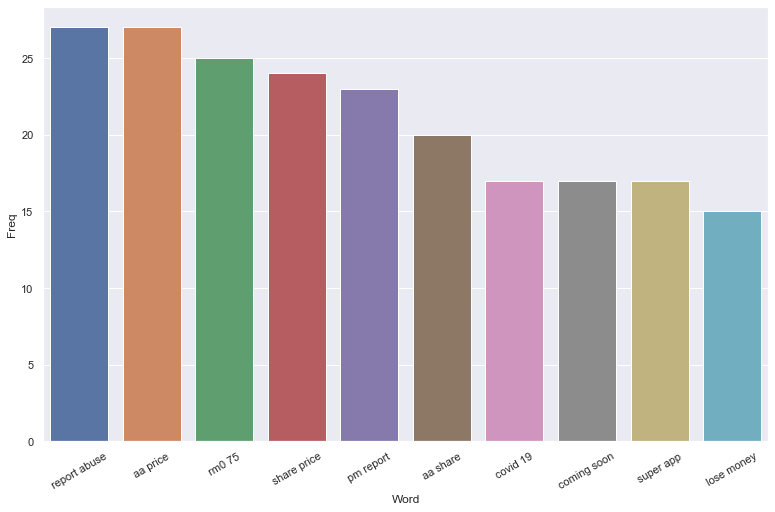

In [31]:
plot_top_n_words(topn)